# **Project 2:** Classifying players from William Shakespeare's Drama Lines

**Author:** Ishrak Hayet<br>**Date:** 09/21/2020

In this project, we work with a dataset containing the lines from William Shakespeare's plays. We also have a column that depicts the player who is saying a line. Our goal for this project will be to train a Natural Language Processing model with engineered features to identify a character from a given line.

The data analysis and classification workflow will be as follows:

1) Creating a wordcloud for each player to get a visual description of word frequencies for each player

2) Engineering features from the dataset

3) Splitting the dataset into training, validation and testing set

4) Training the following classifiers using the engineered features

5) Model evaluation

---

## **Step 1:** Importing the required packages and loading saved models

In [2]:
#Basic packages
import numpy as np
import pandas as pd
import math
import category_encoders as ce

#Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

#Wordcloud packages
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#NLP packages
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

#Model storage
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ISHRA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ISHRA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ISHRA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Loading the saved Shakespeare_Word2Vec.sav model using pickle

In [3]:
filename = '../models/Shakespeare_Word2Vec.sav'
Shakespeare_Word2Vec_Model = pickle.load(open(filename, 'rb'))

---

## **Step 2:** Reading the dataset

In [4]:
data = pd.read_csv("../data/raw/Shakespeare_data.csv")
data.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


A description of the columns of the dataset is as follows:

**Dataline**: Sequence of numbers to identify an index

**Play**: Name of the play from which we have the current play line

**PlayerLineNumber**: This is the number of a line that is spoken by a player. A sequence of contiguous lines can be spoken by the same player and those will all be identified as the same line number. This can be thought of more like a paragraph for every instance of dialog for a player.

**ActSceneLine**: This is a dot separated value consisting of three sub-values. The first sub-value represents the act number. The second sub-value represents the scene number. The third sub-value represents the line number.

**Player**: Name of the player who is saying the current line

**PlayerLine**: The line that is being spoken by the current player

---

## **Step 3:** Preprocessing

Let's take a look at the datatypes for each of the columns

In [5]:
data.dtypes

Dataline              int64
Play                 object
PlayerLinenumber    float64
ActSceneLine         object
Player               object
PlayerLine           object
dtype: object

#### Removing the Dataline column
The Dataline column represents a monotonically increasing sequence for indexing the dataset. Since, we will not be using this indexing, we can drop this column.

In [6]:
if 'Dataline' in data.columns:
    data.drop(['Dataline'], axis=1, inplace=True)

#### Removing tuples with missing values of "ActSceneLine" and "Player"

After taking a look at the dataset, we can be certain that the tuples having NaN values for "ActSceneLine" and "Player" contain lines that are not spoken by a player. These lines will not be useful since our goal is to identify players from spoken lines. So, we remove these tuples from the dataset.

In [7]:
data.dropna(axis=0, subset=['Player', 'ActSceneLine'], inplace=True)

#### Preprocessing PlayerLine

Now, we will convert the PlayerLine words to lowercase for the convenience of analysis.

In [8]:
data['PlayerLine'] = data['PlayerLine'].str.lower()

We will now remove the punctuation marks from the PlayerLine column since these punctuation marks will not be useful for the analysis.

In [9]:
data['PlayerLine'] = data['PlayerLine'].apply(lambda line: re.sub(r'[^A-Za-z0-9 ]', '', line))

At this point, we will tokenize the PlayerLines by words.

In [10]:
data['PlayerLine'] = data['PlayerLine'].apply(lambda line: word_tokenize(line))

Then, we will remove the stop words from the PlayerLine column since the stop words are also not useful for identifiability.

In [11]:
stop_words = stopwords.words('english')

data['PlayerLine'] = data['PlayerLine'].apply(lambda line: [w for w in line if not w in stop_words])

Finally, we will use lemmatization to find the root of words so that we are creating as much of a common lexical ground as possible regardless of the sentence structures. The reason for using lemmatization instead of stemming is because lemmatization derives more accurate roots (lemmas) of words since it performs a complete morphological analysis [1]. We will use the WordNet [2] lemmatizer from nltk to perform the lemmatization.

In [12]:
data['PlayerLine'] = data['PlayerLine'].apply(lambda line: [WordNetLemmatizer().lemmatize(w) for w in line])

## **Step 4:** Feature Engineering

#### Binary Encoding the Play column

The "Play" column is a categorical variable and the values are strings. Since string values have a lot of entropy, these might not be useful for the classifer. Therefore, we encode the "Play" column into binary values. The reason for using binary encoder instead of one hot encoder is to reduce the number of columns. In one hot encoding we get as many number of columns as the number of unique values in a column. As a result, the classifier can suffer from the curse of dimensionality which suggests that when we have more features, we need higher number of data. On the other hand, binary encoder generates as many columns as the binary logarithm of the number of unique values. Consequently, we get exponentially fewer columns than that of one hot encoding.

In [13]:
playEncoder = ce.BinaryEncoder(cols=['Play'])

data = playEncoder.fit_transform(data)

if 'Play' in data.columns:
    data.drop(['Play'], axis=1, inplace=True)

data.head()

,Play_0,Play_1,Play_2,Play_3,Play_4,Play_5,Play_6,PlayerLinenumber,ActSceneLine,Player,PlayerLine
3,0,0,0,0,0,0,1,1.0,1.1.1,KING HENRY IV,"[shaken, wan, care]"
4,0,0,0,0,0,0,1,1.0,1.1.2,KING HENRY IV,"[find, time, frighted, peace, pant]"
5,0,0,0,0,0,0,1,1.0,1.1.3,KING HENRY IV,"[breathe, shortwinded, accent, new, broil]"
6,0,0,0,0,0,0,1,1.0,1.1.4,KING HENRY IV,"[commenced, strand, afar, remote]"
7,0,0,0,0,0,0,1,1.0,1.1.5,KING HENRY IV,"[thirsty, entrance, soil]"


#### Label Encoding the Player column

The "Player" column is our target feature. For the convenience of classification, let us encode the "Player" column using numerical labels.

In [14]:
if data.dtypes['Player'] == 'object':
    playerEncoder = ce.OrdinalEncoder()
    
    data['Player'] = playerEncoder.fit_transform(data['Player'])

print(playerEncoder.category_mapping)
data.head()

[{'col': 'Player', 'mapping': KING HENRY IV      1
WESTMORELAND       2
FALSTAFF           3
PRINCE HENRY       4
POINS              5
                ... 
PERDITA          931
DORCAS           932
MOPSA            933
Shepard          934
NaN               -2
Length: 935, dtype: int64, 'data_type': dtype('O')}]


,Play_0,Play_1,Play_2,Play_3,Play_4,Play_5,Play_6,PlayerLinenumber,ActSceneLine,Player,PlayerLine
3,0,0,0,0,0,0,1,1.0,1.1.1,1,"[shaken, wan, care]"
4,0,0,0,0,0,0,1,1.0,1.1.2,1,"[find, time, frighted, peace, pant]"
5,0,0,0,0,0,0,1,1.0,1.1.3,1,"[breathe, shortwinded, accent, new, broil]"
6,0,0,0,0,0,0,1,1.0,1.1.4,1,"[commenced, strand, afar, remote]"
7,0,0,0,0,0,0,1,1.0,1.1.5,1,"[thirsty, entrance, soil]"


#### Decomposing the "ActSceneLine" column

In the ActSceneLine column, we have values that represent act.scene.line. The act, scene and line numbers might be useful to give a hierarchical insight. Therefore, we decompose the "ActSceneLine" column into three different columns. Then, we can drop the "ActSceneLine" column.

In [15]:
if not set(['Act', 'Scene', 'Line']).issubset(set(data.columns)):
    temp = data['ActSceneLine'].str.split('.', expand=True)
    temp.columns = ['Act', 'Scene', 'Line']

    data = pd.concat([data, temp], axis=1)

if 'ActSceneLine' in data.columns:
    data.drop(['ActSceneLine'], axis=1, inplace=True)
    
data.head()

,Play_0,Play_1,Play_2,Play_3,Play_4,Play_5,Play_6,PlayerLinenumber,Player,PlayerLine,Act,Scene,Line
3,0,0,0,0,0,0,1,1.0,1,"[shaken, wan, care]",1,1,1
4,0,0,0,0,0,0,1,1.0,1,"[find, time, frighted, peace, pant]",1,1,2
5,0,0,0,0,0,0,1,1.0,1,"[breathe, shortwinded, accent, new, broil]",1,1,3
6,0,0,0,0,0,0,1,1.0,1,"[commenced, strand, afar, remote]",1,1,4
7,0,0,0,0,0,0,1,1.0,1,"[thirsty, entrance, soil]",1,1,5


#### Vectorizing the PlayerLine

PlayerLine values are now a list of tokens. Such a list of strings is not a suitable feature for classifiers. So, we convert each token into vectors using the pretrained *Shakespeare_Word2Vec.sav* model. Then, we take the average of the list of words for every sentence to represent that sentence's vector.

In [16]:
def computeSentenceVector(frame):    
    vec = [Shakespeare_Word2Vec_Model.wv[w] for w in frame['PlayerLine']]
    frame['PlayerLineEncoded'] = np.average(vec)
    
    return frame

In [17]:
data = data.apply(computeSentenceVector, axis=1)

C:\Program Files\Python3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Program Files\Python3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In this step, we impute the nan values of PlayerLineEncoded to 0.

In [18]:
data['PlayerLineEncoded'] = data['PlayerLineEncoded'].fillna(0)
data['PlayerLineEncoded'].describe()

count    105152.000000
mean         -0.000024
std           0.000160
min          -0.000930
25%          -0.000124
50%          -0.000022
75%           0.000075
max           0.000994
Name: PlayerLineEncoded, dtype: float64

## **Step 5:** Exploring the Engineered Dataset using Visualization

### Wordcloud Generation

Wordclouds are an interesting technique to visualize word frequencies in a given text. Since our goal is to classify players from the other features, we will group the dataset by "Player" column and create a wordcloud for each player. This might be useful to explore the word usage frequencies for every player.

Since there are many players, visualizing all of them at once might not be feasible. Therefore, we take a subset of players and create wordclouds.

In [19]:
def showWordCloud(frame):
    cloudMask = np.array(Image.open("../data/external/william-shakespeare-black-silhouette.jpg"))
    
    playerLine = " ".join([w for line in frame['PlayerLine'] for w in line])
    
    wordCloud = WordCloud(max_font_size=100, background_color="white", mask=cloudMask)
    wordCloud.generate(playerLine)
    
    # Display the word cloud 
    ax = plt.gca()
    ax.set_title(frame['Player'].iloc[0])
    
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.show()

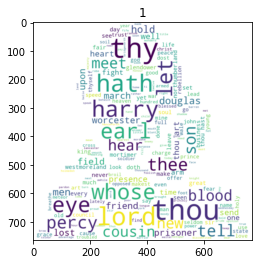

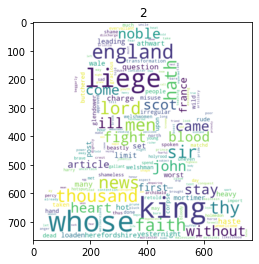

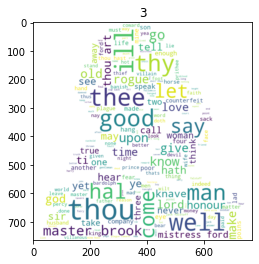

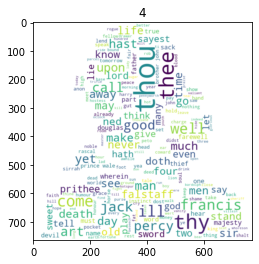

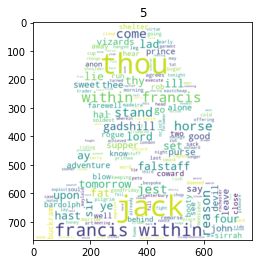

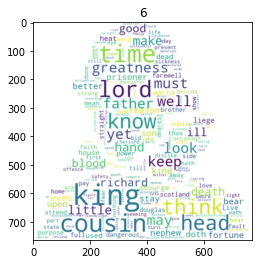

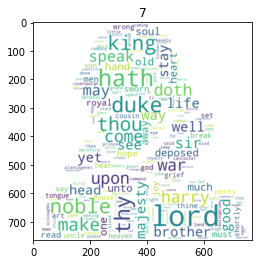

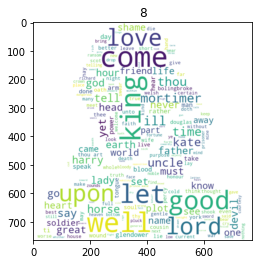

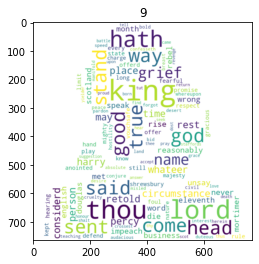

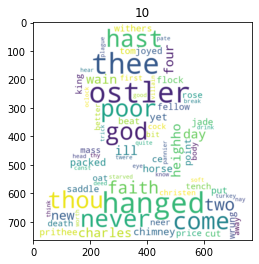

In [20]:
groupedData = data.groupby(['Player'])

groupKeys = list(groupedData.groups.keys())

for i in range(0, 10):
    showWordCloud(groupedData.get_group(groupKeys[i]))

From the wordclouds, we can see that the players having an incomplete silhouette of Shakespeare, have fewer lines.

## **Step 6:** Classifying Players from the Rest of the Features

In [21]:
X = data.drop(['Player', 'PlayerLine'], axis=1)
y = data['Player']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X.head()

,Play_0,Play_1,Play_2,Play_3,Play_4,Play_5,Play_6,PlayerLinenumber,Act,Scene,Line,PlayerLineEncoded
3,0,0,0,0,0,0,1,1.0,1,1,1,0.000246
4,0,0,0,0,0,0,1,1.0,1,1,2,0.000017
5,0,0,0,0,0,0,1,1.0,1,1,3,-0.000016
6,0,0,0,0,0,0,1,1.0,1,1,4,0.000047
7,0,0,0,0,0,0,1,1.0,1,1,5,0.000184


#### SVM Classifier

In [28]:
svmClassifier = LinearSVC(tol=0.001, max_iter=500)

svmClassifier.fit(X_train, y_train)

C:\Program Files\Python3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)

#### RandomForest Classifier

In [124]:
randomForestClassifier = RandomForestClassifier(max_depth=15, random_state=0, class_weight='balanced')

randomForestClassifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## **Step 7:** Evaluation

#### SVM Classifier

In [29]:
svmPredicted = svmClassifier.predict(X_test)
report = classification_report(y_test, svmPredicted)

print(report)

              precision    recall  f1-score   support

           1       0.50      0.11      0.17        66
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00       230
           4       0.00      0.00      0.00       110
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        31
           7       0.00      0.00      0.00        41
           8       0.00      0.00      0.00       114
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00        43
          15       0.00      0.00      0.00        16
          16       0.00      0.00      0.00         5
          17       0.00      0.00      0.00         1
          18       0.00    

C:\Program Files\Python3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The SVM classifier seems to perform very poorly for this dataset. Increasing the max_iter hyperparameter could improve performance. But, another big issue could have been the lack of normalization. Since, the dataset is inherently discrete, normalization didn't feel like the right thing to do. And after some research online, I have found that, SVM convergence depends largely on the scaling of its features between 0 and 1. Therefore, I chose to go with RandomForest classifier next.

#### RandomForest Classifier

In [129]:
predicted = randomForestClassifier.predict(X_test)
report = classification_report(y_test, predicted)

print(report)

              precision    recall  f1-score   support

           1       0.81      0.85      0.83        66
           2       0.33      0.41      0.37        17
           3       0.80      0.33      0.46       230
           4       0.53      0.53      0.53       110
           5       0.14      0.56      0.23         9
           6       0.55      0.74      0.63        31
           7       0.80      0.39      0.52        41
           8       0.79      0.33      0.47       114
           9       0.32      0.88      0.47         8
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         1
          12       0.25      0.75      0.38         4
          13       0.50      0.78      0.61         9
          14       0.53      0.19      0.28        43
          15       0.25      0.12      0.17        16
          16       0.75      0.60      0.67         5
          17       1.00      1.00      1.00         1
          18       0.00    

C:\Program Files\Python3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see that, using the RandomForest Classifier with a depth of 15, we have a moderate overall accuracy of 58%. However, there were quite a few classes that were not detected properly. I believe the primary reason for this is that those classes had very few cases. We could use SMOTE or any other oversampling techniques to balance the classes. That could possibly lead to better precision and recall for the unidentified classes. At the same time, using a deeper RandomForest Classifier might also improve the accuracy of the model. The max_depth hyperparameter can be tuned to get an optimum result.

## References

1. https://towardsdatascience.com/text-cleaning-methods-for-natural-language-processing-f2fc1796e8c7
2. Princeton University "About WordNet." WordNet (https://wordnet.princeton.edu/). Princeton University. 2010.
3. Dataset - https://www.kaggle.com/kingburrito666/shakespeare-plays